In [1]:
# Using uncalibrated airplane data, generate baseline and antenna calibrations for a given day
#
# Author: Brian Pitzel
# Date Created: 3 March 2025
# Date Modified: 3 March 2025

import numpy as np
import h5py 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import datetime
import csv
import glob
import pickle
import pymap3d as pm
from datetime import timezone
import warnings
import helpers.airplanes as ap
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib widget

vfromtimestamp = np.vectorize(datetime.datetime.fromtimestamp)
vutcfromtimestamp = np.vectorize(datetime.datetime.utcfromtimestamp)

In [2]:
# hard-coded magic numbers needed for the script

# download aircraft data only if it falls within these lat/lon boundaries
# west, south, east, north
BOUNDS = (-109.375, 50.771, -106.0, 52.765)

# location of the ICEBEAR receiver
RX = (52.24393, -106.45025, 0)

# convert feet to meters
FT_TO_M = 1 / 3.281


# plotting stuff
fig_width_inches = 17
fig_height_inches = 10
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

In [3]:
# inputs to the script:
# ymd - date of the day to calibrate on (will use data from all 24 hours unless otherwise specified)
# level1_files - UNCALIBRATED level 1 data (range correction applied, NO rx calibration applied)

y = 2020
m = 12
d = 12

# don't change these unless you want specific hours included/excluded
h = 0
n_hours = 24
level1_files = []
for i in range(n_hours):
    level1_files.append(f'/mnt/NAS/range-corrected-data/L1-no-cal/{y}/{m:02d}/{y}_{m:02d}_{(d):02d}/ib3d_normal_01dB_1000ms_{y}_{m:02d}_{(d):02d}_{(h+i):02d}_prelate_bakker.h5')


In [8]:
# unleash the beast

In [10]:
# first, find all of the airplane echoes in the level1_data.
# this allows us to pull airplane data at the proper times, instead of pulling ALL data from the entire day

t_start = datetime.datetime(y, m, d, 0, 0, 0, tzinfo=timezone.utc)
t_end = datetime.datetime(y, m, d, 23, 59, 59, tzinfo=timezone.utc)

airplane_xspectra, airplane_echo_time = ap.load_level1_airplane_xspectra(level1_files, t_start, t_end)
# now, for all of the timestamps at which there is airplane echoes, load in the airplane data
time_filter = np.ones(airplane_echo_time.shape, dtype=np.bool)
aircrafts_dbs = ap.retrieve_airplane_data(airplane_echo_time, time_filter, BOUNDS)

ap.save_aircrafts_dbs(aircrafts_dbs, f'{y}-{m:02d}-{d:02d}')


2020-12-12 00:00:00+00:00 2020-12-12 23:59:59+00:00
Excepted [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/NAS/range-corrected-data/L1-no-cal/2020/12/2020_12_12/ib3d_normal_01dB_1000ms_2020_12_12_15_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Continuing...
Excepted [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/NAS/range-corrected-data/L1-no-cal/2020/12/2020_12_12/ib3d_normal_01dB_1000ms_2020_12_12_16_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Continuing...
Excepted [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/NAS/range-corrected-data/L1-no-cal/2020/12/2020_12_12/ib3d_normal_01dB_1000ms_2020_12_12_17_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Continuing...
Excepted [Errno 2] Unable to synchronously open file (unable to op

0.00% [00:00, ?%/s]
DOWNLOAD: 1.00lines [00:00, 211lines/s]
FINISHED: : 0.00% [00:00, ?%/s]
DOWNLOAD: 42.0lines [00:00, 8.78klines/s]
0.00% [00:00, ?%/s]
DOWNLOAD: 1.00lines [00:00, 223lines/s]
FINISHED: : 100% [00:00, 492%/s]
DOWNLOAD: 261lines [00:00, 47.0klines/s]
FINISHED: : 100% [00:00, 491%/s]
DOWNLOAD: 107lines [00:00, 21.7klines/s]
FINISHED: : 0.00% [00:00, ?%/s]
DOWNLOAD: 22.0lines [00:00, 4.52klines/s]
0.00% [00:00, ?%/s]
DOWNLOAD: 1.00lines [00:00, 219lines/s]
FINISHED: : 0.00% [00:00, ?%/s]
DOWNLOAD: 119lines [00:00, 22.4klines/s]
0.00% [00:00, ?%/s]
DOWNLOAD: 1.00lines [00:00, 214lines/s]
FINISHED: : 100% [00:00, 328%/s] 
DOWNLOAD: 135lines [00:00, 25.0klines/s]
FINISHED: : 66.7% [00:00, 164%/s]
DOWNLOAD: 88.0lines [00:00, 18.2klines/s]
FINISHED: : 66.7% [00:00, 326%/s]
DOWNLOAD: 6.00lines [00:00, 1.29klines/s]
FINISHED: : 0.00% [00:00, ?%/s]
DOWNLOAD: 41.0lines [00:00, 8.32klines/s]
FINISHED: : 0.00% [00:00, ?%/s]
DOWNLOAD: 7.00lines [00:00, 1.52klines/s]
FINISHED: : 91.7

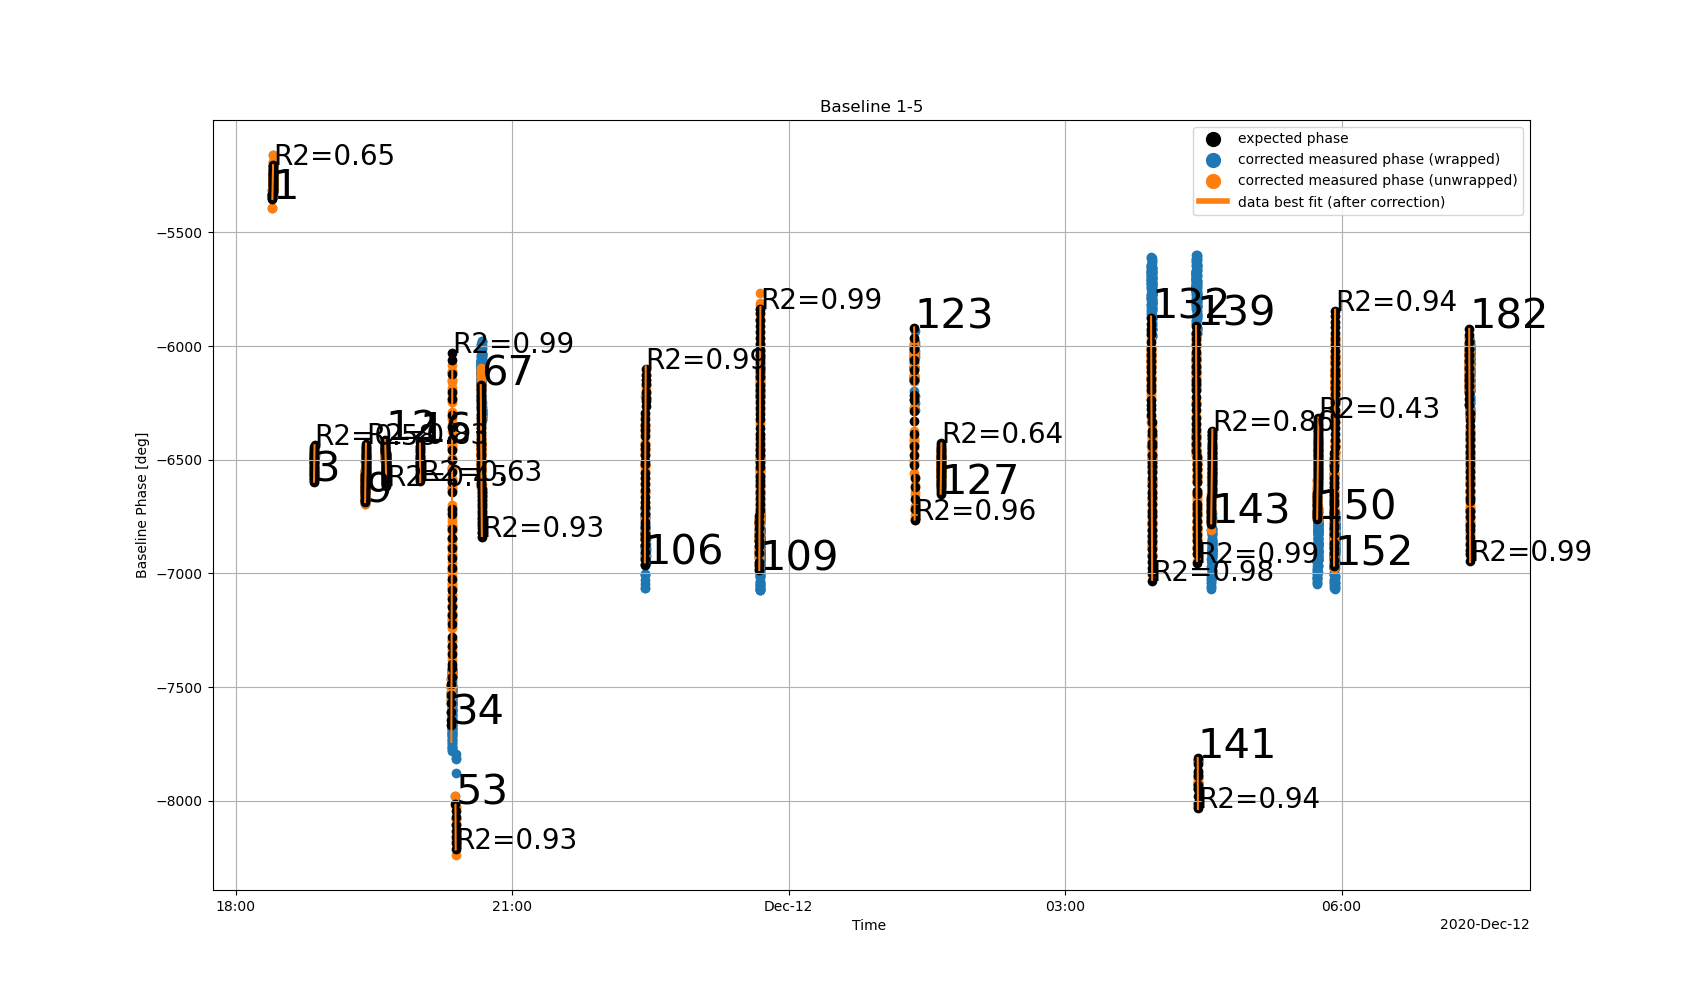

In [13]:
# now, progress through the airplanes, one at a time.
# calculate the expected phase of the airplane on each baseline, and compare it to the
# measured xspectra phase
# also make a sample plot to assist in picking out the good airplanes

baseline_to_plot = [1, 5]

fig, ax = plt.subplots()
fig.set_size_inches(fig_width_inches, fig_height_inches)
ax.set_ylabel('Baseline Phase [deg]')
ax.set_xlabel('Time ')
ax.set_title(f'Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]}')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid()


total_corrections = []

airplane_idx = 0
# ON THE FIRST RUN THROUGH, UNCOMMENT THIS LINE.
# ON THE SECOND RUN THROUGH, COMMENT THIS LINE AND FILL IN THE LIST AS NEEDED        
#plane_indices = []

#plane_indices = [0,1,7,9,10,14,20,25,27,29,33,39,40,46,47,48] # 13/03/2021
plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182] # 12/12/2020

for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.
        # ON THE FIRST RUN THROUGH, UNCOMMENT THIS LINE.
        # ON THE SECOND RUN THROUGH, COMMENT THIS LINE.
        #plane_indices.append(airplane_idx)

        if airplane_idx not in plane_indices:
            airplane_idx += 1
            continue
        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]

        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        #ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        #tf = tf.replace(tzinfo=None)
        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)
        az = -az + 90 # convert to NORTH OF East angles
        
        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
        
        # now, we compare this airplane data to baseline data
        this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
        this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, :]
        this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]
        
        corrections_this_airplane = [] # a full set of baseline corrections from a single airplane
        
        baseline = 0
        for antenna1 in range(10):
            for antenna2 in range(antenna1+1, 10):
                # obtain the expected phase of the airplane on the baseline based on the airplane GPS
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_phase = np.rad2deg(expected_phase)

                # obtain the relevant baseline visibility
                vis_phase = np.rad2deg(np.angle(this_airplane_xspectra[:, baseline]))
                
                # unwrap the visibility phase
                tol = 0
                vis_phase_saved = vis_phase
                vis_phase = ap.unwrap_phase(vis_phase, tol=tol)
                
                # calculate a linear best fit for the expected airplane baseline phase 
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())
                m, b_plane = np.polyfit(this_airplane_db_timestamps, expected_phase, deg=1)
                
                # using the slope of that best fit, do least squares regression on the measured data
                # this will find the y-intercept that best matches the measured data to a line with the slope m
                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                b_data, residuals = ap.linear_regression_with_known_slope2(this_airplane_echo_timestamps, vis_phase, m)
                R2 = 1 - residuals / (vis_phase.shape[0] * vis_phase.var())

                # np.save(f'data-magnus-day-azimuth-corrected/airplane_phase{antenna1}{antenna2}-plane{airplane_idx}.npy', airplane_phase)
                # np.save(f'data-magnus-day-azimuth-corrected/vis_phase{antenna1}{antenna2}-plane{airplane_idx}.npy', vis_phase_saved)
                # np.save(f'data-magnus-day-azimuth-corrected/airplane_time{antenna1}{antenna2}-plane{airplane_idx}.npy', timestamps_plane)
                # np.save(f'data-magnus-day-azimuth-corrected/vis_time{antenna1}{antenna2}-plane{airplane_idx}.npy', timestamps_data)

                # plot the best fit line for the predicted baseline phase
                x = np.array([this_airplane_db_timestamps[0], this_airplane_db_timestamps[-1]])
                y = m * x + b_plane
                y1 = y
                x = vfromtimestamp(x)
                #ax.plot(x, y, c='black')
                
                # plot the measured visibility phase and it's best fit line                
                #if np.all(vis_phase) != 0:

                x = np.array([this_airplane_echo_timestamps[0], this_airplane_echo_timestamps[-1]])
                y = m * x + b_data
                y2 = y
                correction = (y2-y1)[0]
                x = vfromtimestamp(x) # don't use vutcfromtimestamp here because the data is already in utc

                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.plot(x, y-correction, c='tab:orange')
                    ax.scatter(vfromtimestamp(this_airplane_echo_timestamps), vis_phase_saved-correction, c='tab:blue')
                    ax.scatter(vfromtimestamp(this_airplane_echo_timestamps), vis_phase-correction, c='tab:orange')
                    ax.scatter(vfromtimestamp(this_airplane_db_timestamps), expected_phase, c='black')
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(this_airplane_db_timestamps)[0], expected_phase[0]), annotation_clip=False, fontsize=30)
                    ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(this_airplane_db_timestamps)[-1], expected_phase[-1]), annotation_clip=False, fontsize=20)
                    
                # record the correction for this baseline
                corrections_this_airplane.append(correction)
                    
                baseline += 1

        corrections_this_airplane = np.array(corrections_this_airplane)
        total_corrections.append(corrections_this_airplane)
        
        airplane_idx += 1
        
total_corrections = np.array(total_corrections)

# make the legend
custom_lines = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='black', markersize=12),
                Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='tab:blue', markersize=12),
                Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='tab:orange', markersize=12),
                Line2D([0], [0], color='tab:orange', lw=4)]

ax.legend(custom_lines, ['expected phase', 'corrected measured phase (wrapped)', 'corrected measured phase (unwrapped)', 'data best fit (after correction)'])

In [14]:
# using the above plot, choose the airplane indices that correspond to good planes and re-run the cell above with the 'planes' variable
#plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182,

print(total_corrections.shape)
total_corrections_copy = total_corrections.copy()
plt.close('all')

(19, 45)


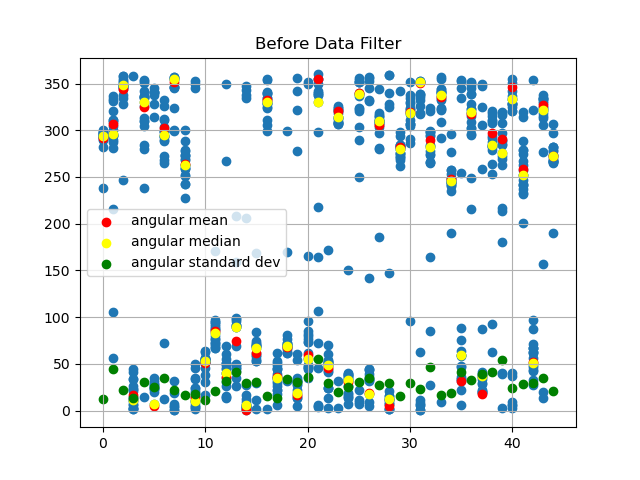

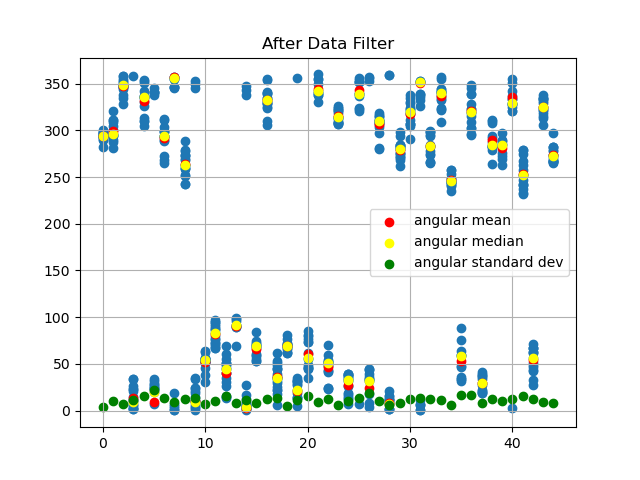

[294.03767335 296.01395798 348.70133543   9.76066589 335.47273445
  20.23655033 294.21634054 355.52146149 262.97417688   9.31239128
  54.22470331  82.6986804   44.24176788  91.1513176    3.8719945
  68.79600573 332.09965754  35.36863136  69.06661987  21.65607929
  55.87703228 341.50325775  51.10181427 314.45905209  32.59030437
 338.81496429  32.17497253 309.45742106   7.55468082 280.44792509
 319.12098598 351.82552528 283.13818216 339.89938545 245.43999672
  58.01689577 319.82717514  29.99469376 284.02099228 284.74977875
 329.58637238 252.39107132  56.2721653  324.93010473 271.99250841]


In [15]:
total_corrections = total_corrections_copy.copy()

n_corrections = total_corrections.shape[0]
fig, ax = plt.subplots()
for plane in range(n_corrections):
    ax.scatter(np.arange(45), total_corrections[plane, :]%360, c='tab:blue')

averaged_corrections = []
median_corrections = []
stdev_corrections = []

# calculate the mean/median etc. 
for baseline in range(45): # total_corrections already has the planes selected from above
    median = ap.angular_median(np.deg2rad(total_corrections[:, baseline]%360))
    mean, stdev = ap.angular_mean_and_stdev(np.deg2rad(total_corrections[:, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))

averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

averaged_corrections_old = averaged_corrections.copy()
median_corrections_old = median_corrections.copy()
stdev_corrections_old = stdev_corrections.copy()

ax.scatter(np.arange(45), averaged_corrections, c='red', label='angular mean')
ax.scatter(np.arange(45), median_corrections, c='yellow', label='angular median')
ax.scatter(np.arange(45), stdev_corrections, c='green', label='angular standard dev')
ax.legend()
ax.set_title('Before Data Filter')
ax.grid()
plt.show()


# ---------------------------------------------------------------------

# now, do it again but exclude outlier points based on the mean
outliers = np.zeros(total_corrections.shape, dtype=np.bool)
for baseline in range(45):
    difference1 = np.abs(total_corrections[:, baseline]%360 - median_corrections[baseline])
    difference2 = np.abs(total_corrections[:, baseline]%360 - median_corrections[baseline] + 360)
    difference3 = np.abs(total_corrections[:, baseline]%360 - median_corrections[baseline] - 360)
    outlier = np.minimum(np.minimum(difference1, difference2), difference3) > 30
    outliers[outlier, baseline] = True

fig, ax = plt.subplots()
for plane in range(n_corrections):
    not_outliers = ~outliers[plane, :]
    ax.scatter(np.arange(45)[not_outliers], total_corrections[plane, not_outliers]%360, c='tab:blue')

averaged_corrections = []
median_corrections = []
stdev_corrections = []

for baseline in range(total_corrections.shape[1]): # total_corrections already has the planes selected from above
    not_outliers = ~outliers[:, baseline]
    median = ap.angular_median(np.deg2rad(total_corrections[not_outliers, baseline]%360))
    mean, stdev = ap.angular_mean_and_stdev(np.deg2rad(total_corrections[not_outliers, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))


averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

ax.scatter(np.arange(45), averaged_corrections, c='red', label='angular mean')
ax.scatter(np.arange(45), median_corrections, c='yellow', label='angular median')
ax.scatter(np.arange(45), stdev_corrections, c='green', label='angular standard dev')
ax.legend()
ax.set_title('After Data Filter')
ax.grid()

plt.show()

print(median_corrections)

In [16]:
np.save('median_corrections_{y:04d}-{m:02d}-{m:02d}.npy',median_corrections)

In [ ]:
# Level 2 data will now have to be processed before continuing

In [11]:
# inputs to the second part of the script:
# level2_files - the result of processing the uncalibrated level 1 data to level 2 data using the baseline calibrations
#                found in the previous cell. 

# don't change these unless you want specific hours included/excluded
level2_files = []
level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-pos-azimuth_1/{y}/{m:02d}/{y}_{m:02d}_{(d):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d):02d}_prelate_bakker.h5') # with relaxation
level2_files.append(f'/mnt/NAS/airplane-data/L2_1/{y}/{m:02d}/{y}_{m:02d}_{(d):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d):02d}_prelate_bakker.h5') # without relaxation


/mnt/NAS/airplane-data/L2-new-coeffs-with-pos-azimuth_1/2020/12/2020_12_12/ib3d_normal_swht_2020_12_12_prelate_bakker.h5
/mnt/NAS/airplane-data/L2_1/2020/12/2020_12_12/ib3d_normal_swht_2020_12_12_prelate_bakker.h5


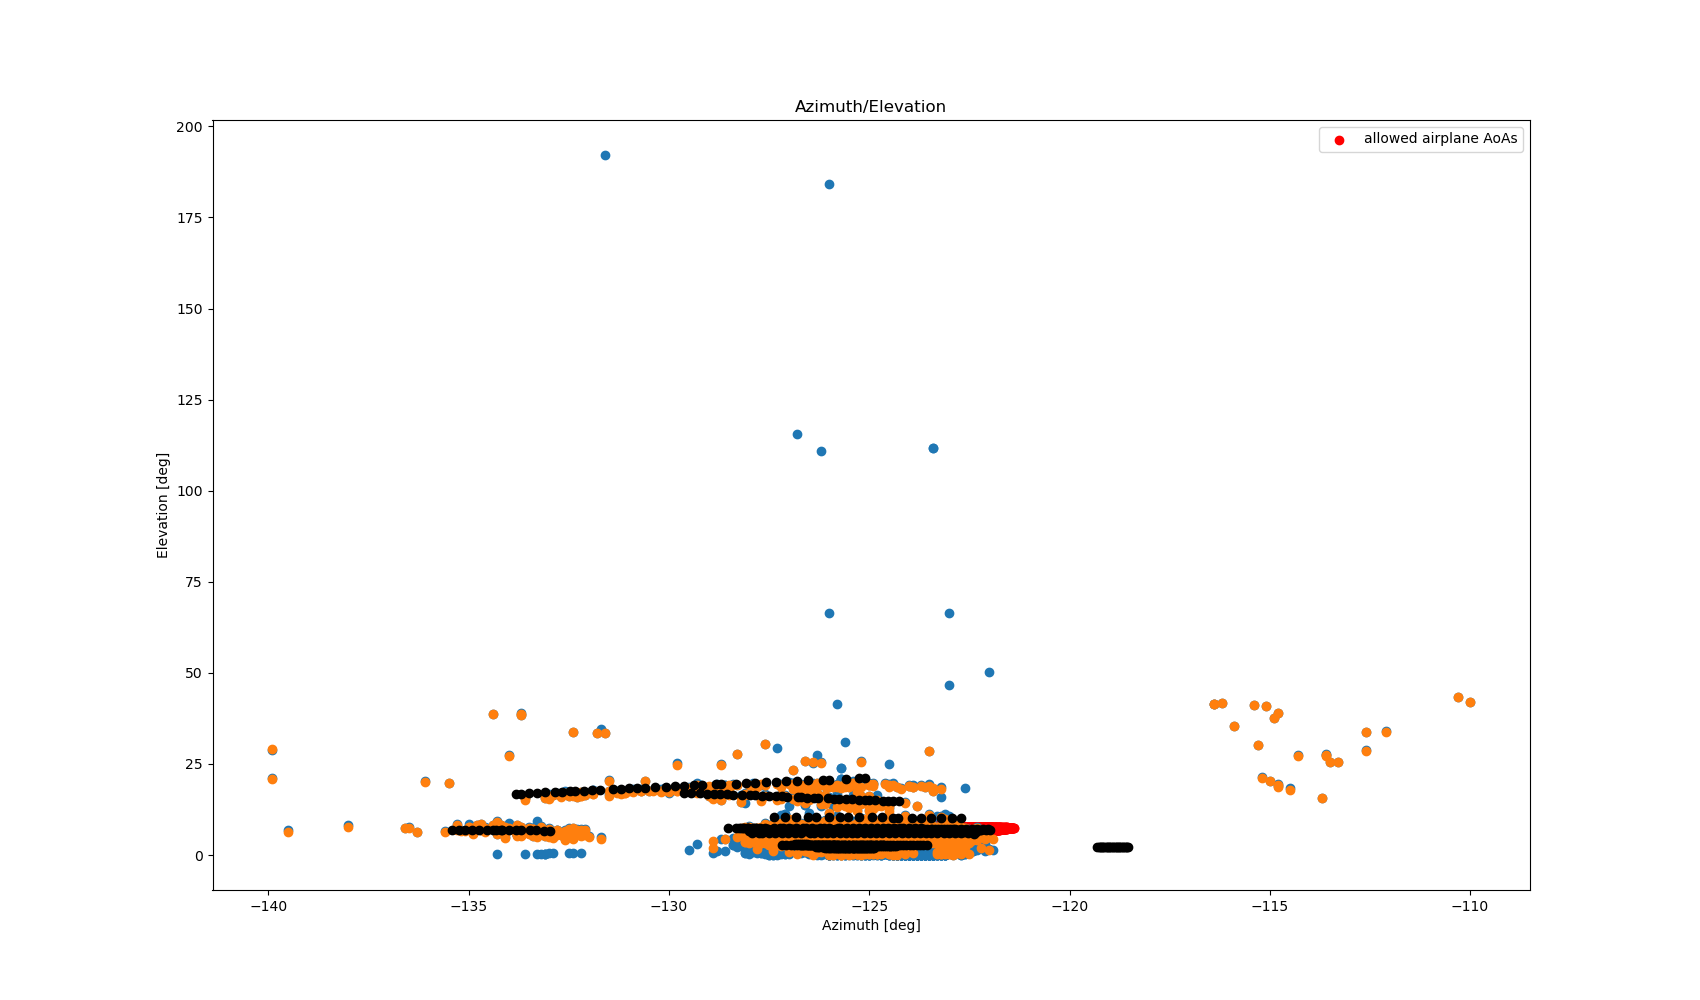

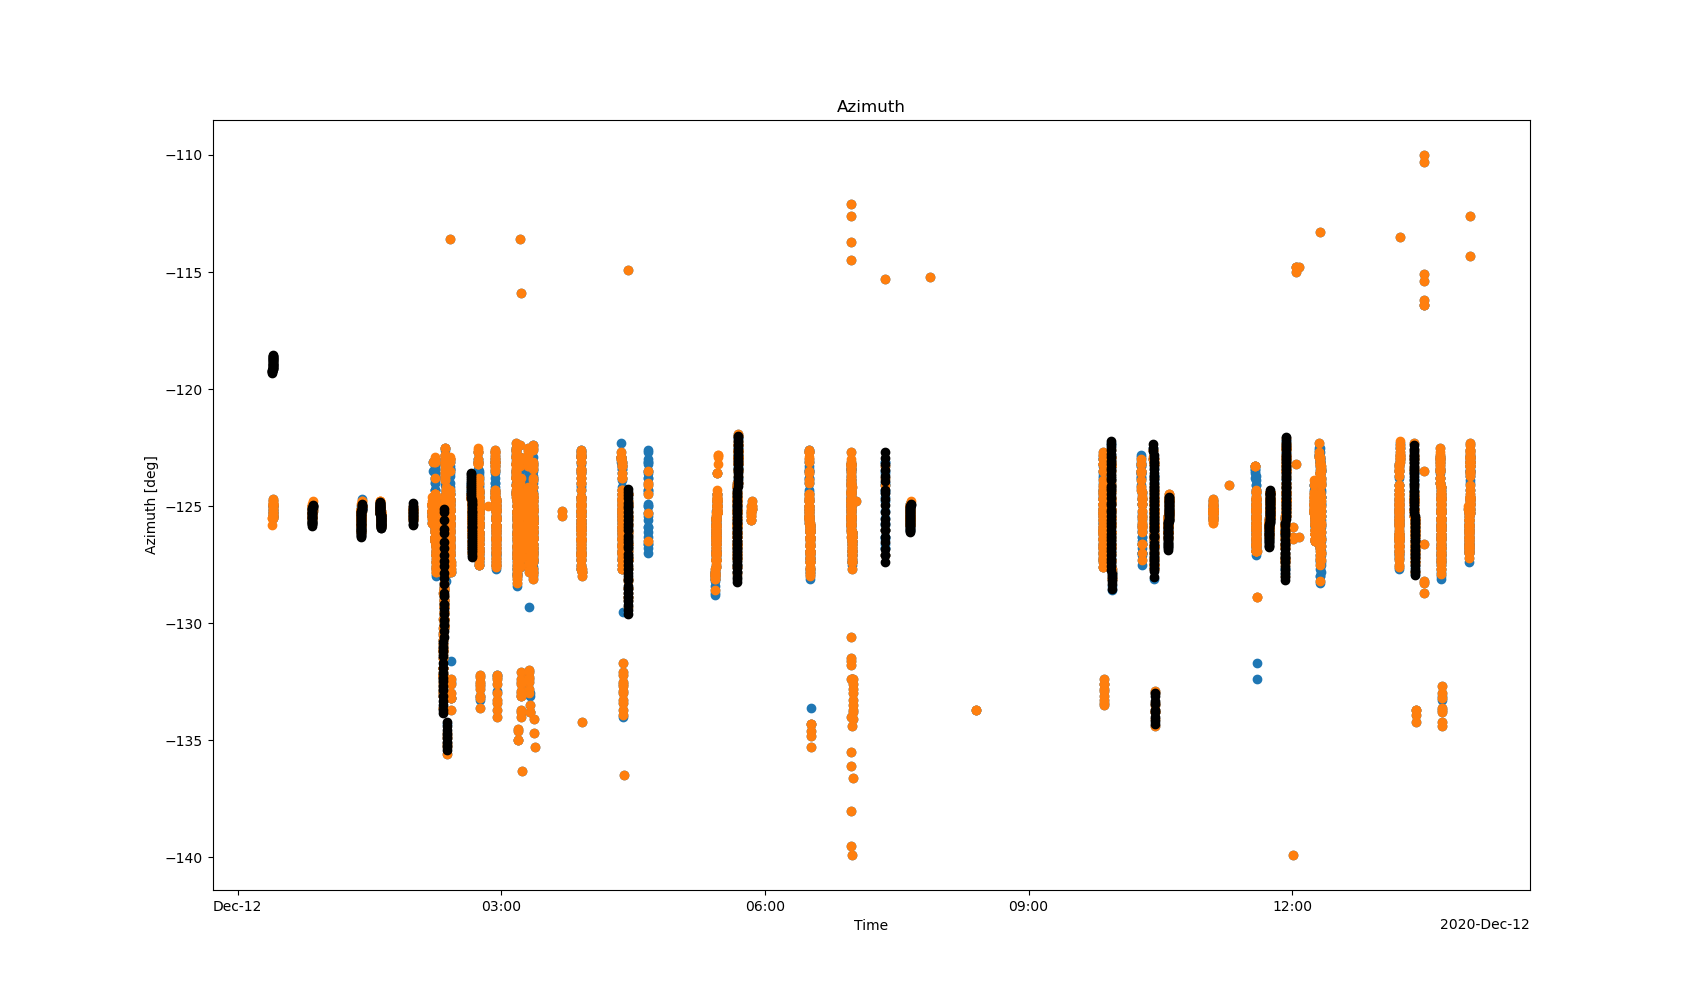

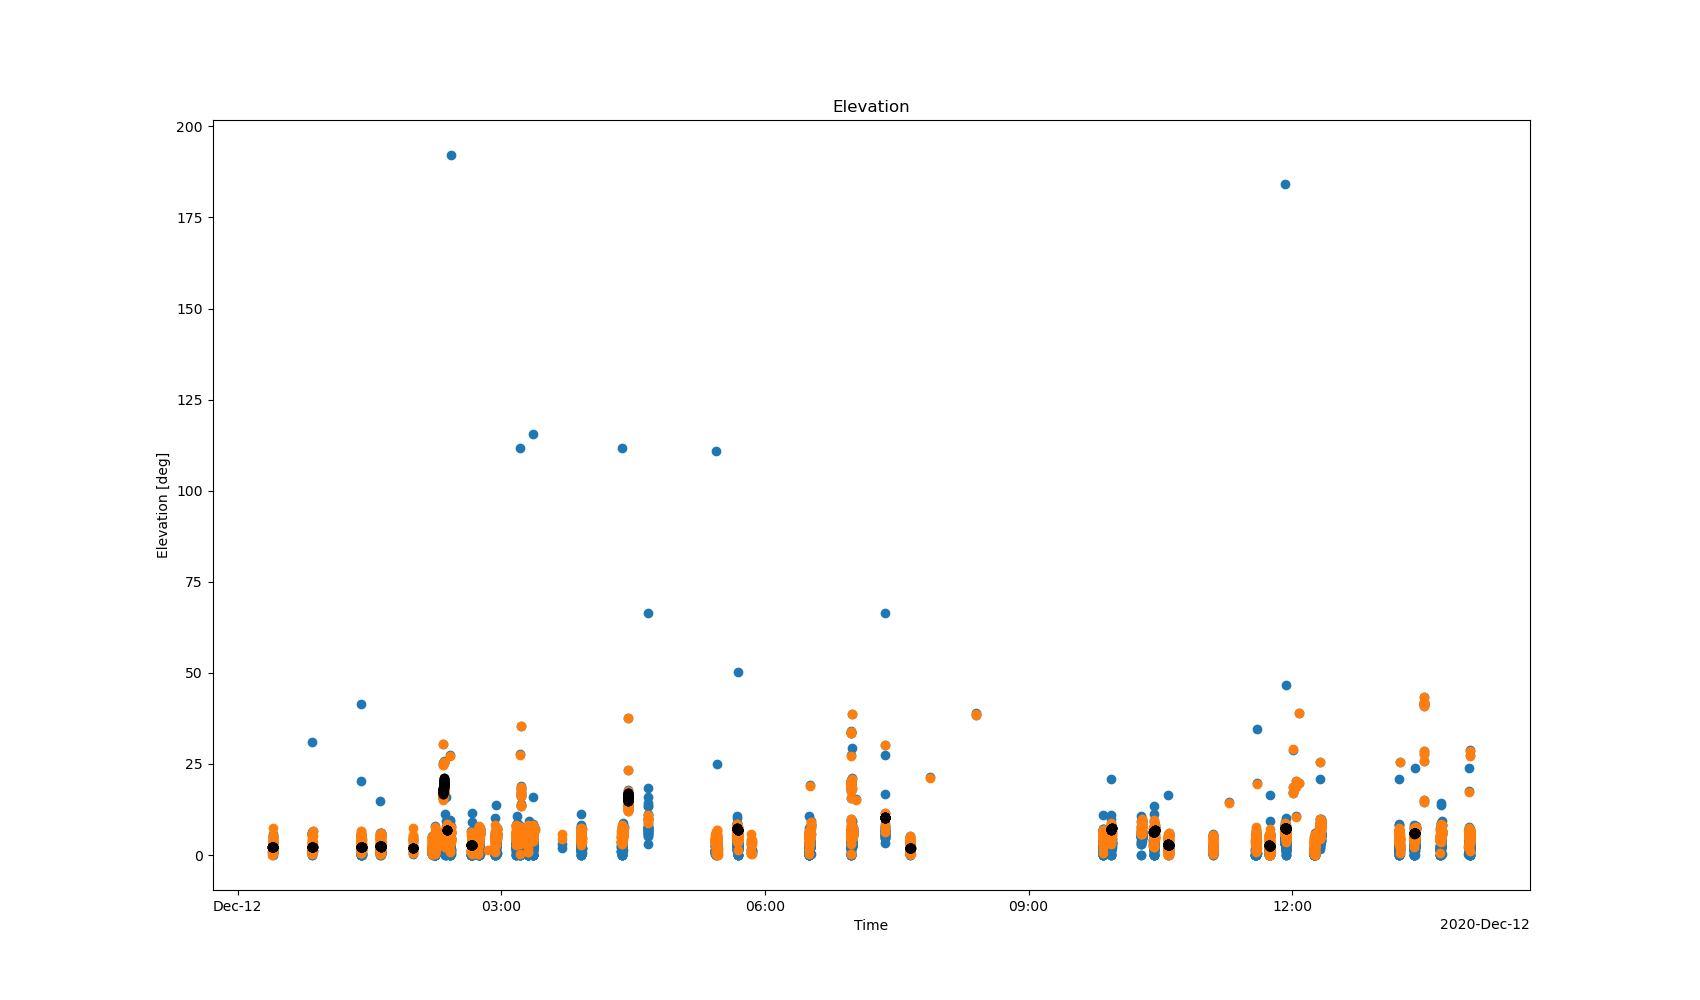

In [12]:
# plot up the level 2 data and the corresponding airplane data
fig_az, ax_az = plt.subplots()
fig_az.set_size_inches(fig_width_inches, fig_height_inches)
ax_az.set_ylabel('Azimuth [deg]')
ax_az.set_xlabel('Time')
ax_az.set_title(f'Azimuth')
ax_az.xaxis.set_major_locator(locator)
ax_az.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_azel, ax_azel = plt.subplots()
fig_azel.set_size_inches(fig_width_inches, fig_height_inches)
ax_azel.set_ylabel('Elevation [deg]')
ax_azel.set_xlabel('Azimuth [deg]')
ax_azel.set_title(f'Azimuth/Elevation')
# plot the allowed az/el polygon (wrt boresight)
az = np.load('allowed_airplane_azimuth.npy')
az = np.where(az > 180.0, az - 360.0, az)
el = np.load('allowed_airplane_elevation.npy')
ax_azel.scatter(az, el, c='red')
ax_azel.legend(['allowed airplane AoAs'])

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)
    
    range_filter = (rf_distance < 256) & (rf_distance > 246)
    
    # plot az and el / time
    ax_az.scatter(utc_time[range_filter], azimuth[range_filter])
    ax_el.scatter(utc_time[range_filter], elevation[range_filter])
    
    # plot az/el
    ax_azel.scatter(azimuth[range_filter], elevation[range_filter])
    
    f.close()

aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{y:04d}-{m:02d}-{d:02d}.pckl')
plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182] # 12/12/2020
airplane_idx = 0
for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.

        if airplane_idx not in plane_indices:
            airplane_idx += 1
            continue

        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]

        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        #ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        #tf = tf.replace(tzinfo=None)
        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)

        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)

        # plot az and el
        ax_el.scatter(this_airplane_db_time, el, c='black')
        ax_az.scatter(this_airplane_db_time, az, c='black')
        ax_azel.scatter(az, el, c='black')

        airplane_idx += 1
        
plt.show()
